In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-sentiment-analysis-hatred-speech:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F100982%2F239192%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240511%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240511T135927Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4d022ab6f1600282a47ca49b773d5e2771b9e8c6fc55f9f68dc1f0eb3333f08495aaedeecbdda57d0275957c8cc627a311f655e6f84eed669d46b8ced76f3900548be47057be47b1fdbf79fae9a7dc667289d78b5f21503235c8d693448257bcfd2fc0ec631b704c51e49e1f7629375bb47c2a6b901b5c6a3a27fa087f238680947f338b998f7c9413e0d7b06ef06f31511bf93b3589d3c3db738e721fb87853f1d4ce418c51dc13191610576297e160376a67760cc0678728097ab585a7c4ffab34562928089ef004182582306e622907eaafcba72546772d07c20d0c804df449a210dd10142249ab87be6ee948f50845258f0b5e8f376fd1831f1f95167471,twittersentimentdata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4265094%2F7345138%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240511%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240511T135927Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D785e7f651c7ebd4e3a4a09b3e49ed9aa58d1b00020a2e168a09aa12921f7134909d885af43e9a4cd1741d3632cb94ba16a49935113095d1b933f895c4d406d0e9b2f8872bb0013abcf41a9f90c7a839e2acb11a854ac5ad433e6640b86e3ad40079a6236f08cebe484cdedeb5273045e9ecbd2b95b6bd10dda4bb6980c9fdb340af3b610ea583ba44302e1e2a427489b2b21cc87a4b2f3ec34d4d3ba100142e864768ce5654ad4d60cf11209977d84ca2edde0e02e558ea24a42489c0417b17558cb30f97dc020147401d374b81b89bd87a0fb6deed7f613699a18568bd264d2fc1d978330b48498bcc647d310214ef5e494532aa4a0b5f0a8e1ba9113678360'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1982527 bytes downloaded
Downloaded and uncompressed: twitter-sentiment-analysis-hatred-speech
[==================================================] 1982527 bytes downloaded
Downloaded and uncompressed: twittersentimentdata
Data source import complete.


In [2]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
train_df = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
test_df = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')

In [4]:
train_df.shape

(31962, 3)

In [5]:
train_df.duplicated().sum()

0

In [6]:
train_df.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [7]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [8]:
test_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
# Plotting Word Clouds
stopwords = set(STOPWORDS)
stopwords.add('user')

def plot_wordcloud(tweets, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(tweets)
    plt.figure(figsize=(14, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontdict={'fontsize': 20})
    plt.show()

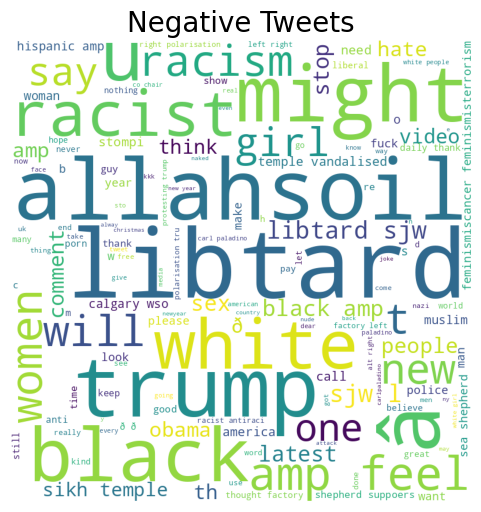

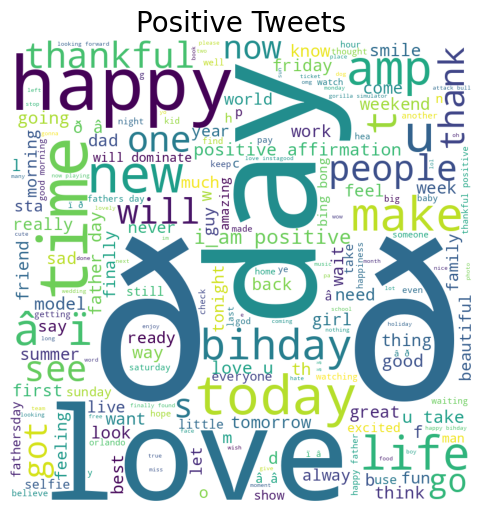

In [10]:
negative_tweets = train_df['tweet'][train_df['label'] == 1].to_string()
positive_tweets = train_df['tweet'][train_df['label'] == 0].to_string()

plot_wordcloud(negative_tweets, 'Negative Tweets')
plot_wordcloud(positive_tweets, 'Positive Tweets')

# Feature Engineering

In [11]:
# Feature Engineering
train_df_fe = train_df.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
train_df_fe['num_exclamation_marks'] = train_df_fe['tweet'].str.count('!')
train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

id  label                                              tweet  tweet_length  \
0   1      0   @user when a father is dysfunctional and is s...           102   
1   2      0  @user @user thanks for #lyft credit i can't us...           122   
2   3      0                                bihday your majesty            21   
3   4      0  #model   i love u take with u all the time in ...            86   
4   5      0             factsguide: society now    #motivation            39   

   num_hashtags  num_exclamation_marks  num_question_marks  total_tags  \
0             1                      0                   0           1   
1             3                      0                   0           2   
2             0                      0                   0           0   
3             1                      3                   0           0   
4             1                      0                   0           0   

   num_punctuations  num_words  
0                 1         18  
1                 1         19  
2                 0          3  
3                 0         14  
4                 1          4

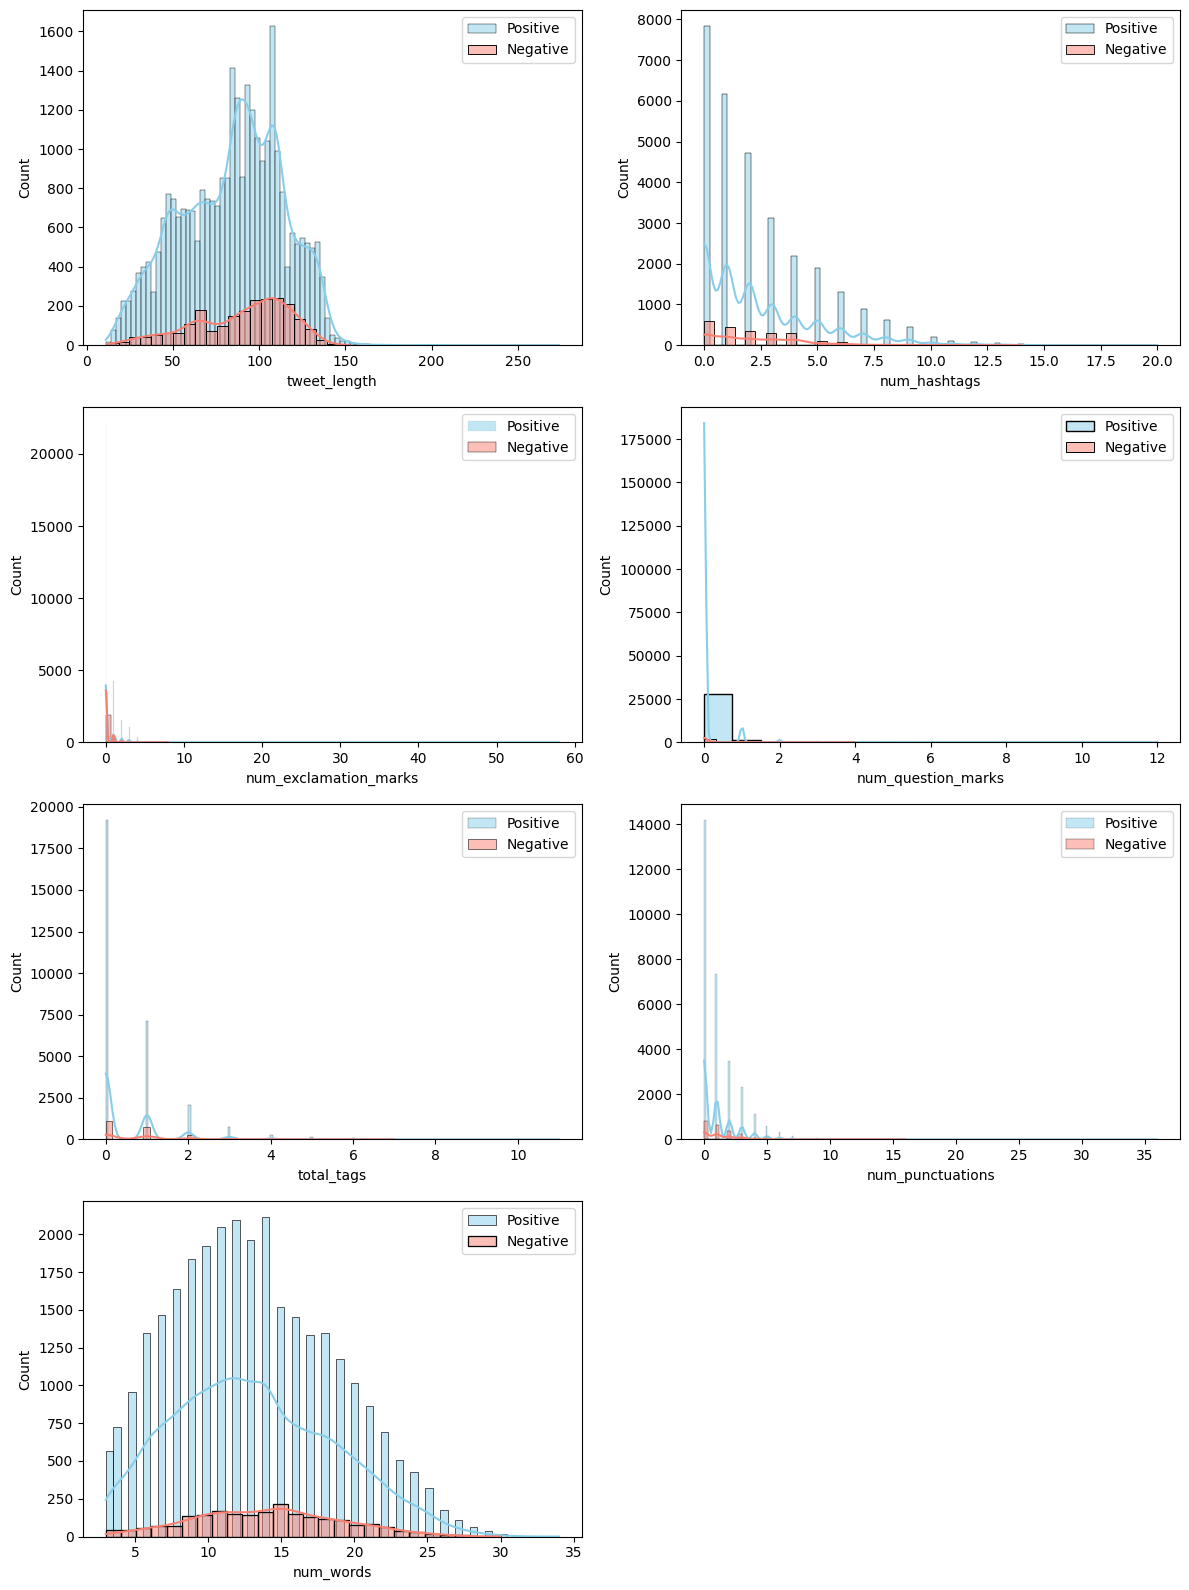

In [12]:
# Visualizing Relationship of Engineered Features with Sentiments
features = ['tweet_length', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 'total_tags', 'num_punctuations', 'num_words']

# Check if train_df_fe has the expected columns
if set(features).issubset(train_df_fe.columns):
    plt.figure(figsize=(12, 16))
    colors = ['skyblue', 'salmon']

    for i, feature in enumerate(features, 1):
        plt.subplot(4, 2, i)
        sns.histplot(train_df_fe[train_df_fe.label == 0][feature], label='Positive', kde=True, color=colors[0])
        sns.histplot(train_df_fe[train_df_fe.label == 1][feature], label='Negative', kde=True, color=colors[1])
        plt.legend()

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [13]:
# Data Preprocessing
X = train_df.drop(columns=['label'])
y = train_df['label']
test = test_df

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Text Normalization

In [17]:
def tokenize_and_clean(text):
    lowered = text.lower()
    cleaned = re.sub('@user', '', lowered)
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

## Vectorization

In [18]:
# TF-IDF Vectorization
import nltk
nltk.download('punkt')

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## SMOTE

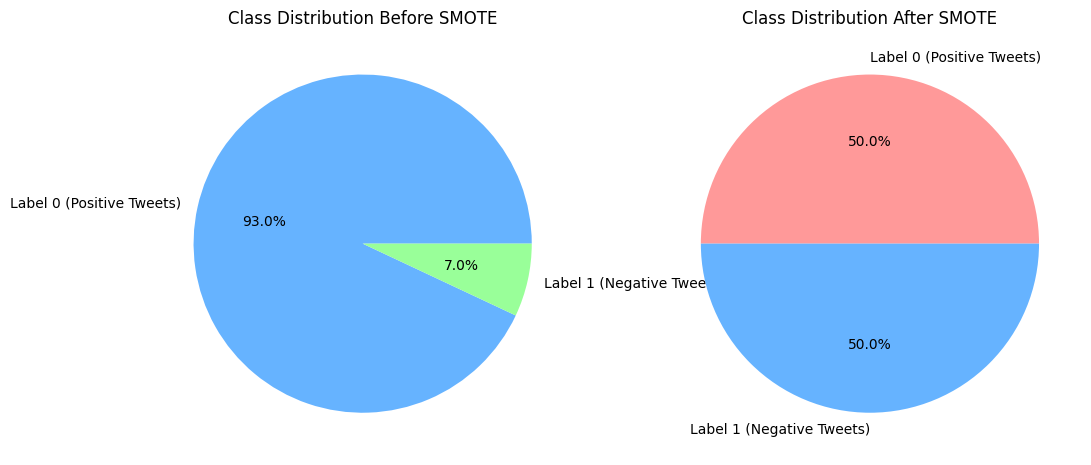

In [19]:
# Class Imbalance Check Before SMOTE
plt.figure(figsize=(12, 6))

# Colors for the pie charts
colors_before_smote = ['#66b3ff', '#99ff99']
colors_after_smote = ['#ff9999', '#66b3ff']

labels = ['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)']

# Plotting before SMOTE
plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=labels, autopct='%0.1f%%', colors=colors_before_smote)
plt.title('Class Distribution Before SMOTE')

# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)

# Plotting after SMOTE
plt.subplot(1, 2, 2)
plt.pie(pd.value_counts(y_train_smote), labels=labels, autopct='%0.1f%%', colors=colors_after_smote)
plt.title('Class Distribution After SMOTE')
plt.show()

# ML Model

In [20]:
# Functions to print scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

In [21]:
# Machine Learning Modeling
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    training_scores(y_train, y_train_pred)
    validation_scores(y_test, y_test_pred)

In [22]:
# Logistic Regression
lr = LogisticRegression()
train_and_evaluate(lr, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.975, F1-Score=0.975
Validation Scores: Accuracy=0.926, F1-Score=0.607


In [23]:
# Naive Bayes Classifier
mnb = MultinomialNB()
train_and_evaluate(mnb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.967, F1-Score=0.967
Validation Scores: Accuracy=0.921, F1-Score=0.609


In [24]:
# Random Forest Classifier
rf = RandomForestClassifier()
train_and_evaluate(rf, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=1.0, F1-Score=1.0
Validation Scores: Accuracy=0.957, F1-Score=0.658


In [25]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_and_evaluate(xgb, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.939, F1-Score=0.937
Validation Scores: Accuracy=0.944, F1-Score=0.605


# Hyperparameter Tuning

In [26]:
rf_tuned = RandomForestClassifier(criterion='entropy',
                                  max_samples=0.8,
                                  min_samples_split=10,
                                  random_state=0)
train_and_evaluate(rf_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.956, F1-Score=0.673


In [27]:
xgb_tuned = XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',
                          learning_rate=0.8,
                          max_depth=20,
                          gamma=0.6,
                          reg_lambda=0.1,
                          reg_alpha=0.1)
train_and_evaluate(xgb_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

Training Scores: Accuracy=0.998, F1-Score=0.998
Validation Scores: Accuracy=0.955, F1-Score=0.654


Your support with an **upvote** would be greatly valued.